In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import NASNetMobile
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

# Check if TensorFlow can access the GPU
tf.test.gpu_device_name()

''

Load and Preprocess the Data

In [ ]:
# Define the paths to your dataset
data_dir = '/content/drive/MyDrive/Laboratory'
positive_dir = os.path.join(data_dir, 'Positive')
negative_dir = os.path.join(data_dir, 'Negative')

# Create lists to store file paths and labels
file_paths = []
labels = []

# Read the Positive images
for file in os.listdir(positive_dir):
    file_paths.append(os.path.join(positive_dir, file))
    labels.append(1)  # Label for positive images

# Read the Negative images
for file in os.listdir(negative_dir):
    file_paths.append(os.path.join(negative_dir, file))
    labels.append(0)  # Label for negative images

# Convert to numpy arrays
file_paths = np.array(file_paths)
labels = np.array(labels)

# Convert labels to a list of strings
labels = labels.astype(str).tolist()

# Split the data into training and testing sets
train_paths, test_paths, train_labels, test_labels = train_test_split(file_paths, labels, test_size=0.2, random_state=42)

# ImageDataGenerator for data augmentation and preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Helper function to create a data generator
def create_generator(file_paths, labels, datagen, batch_size=32):
    return datagen.flow_from_dataframe(
        dataframe=pd.DataFrame({'filename': file_paths, 'class': labels}),
        x_col='filename',
        y_col='class',
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='binary')

# Create generators for training and testing
train_generator = create_generator(train_paths, train_labels, train_datagen)
test_generator = create_generator(test_paths, test_labels, test_datagen, batch_size=1)  # Set batch_size to 1 for testing


Found 384 validated image filenames belonging to 2 classes.
Found 96 validated image filenames belonging to 2 classes.


Build the NASNet Model

In [ ]:
# Load the NASNetMobile model with pre-trained ImageNet weights
base_model = NASNetMobile(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

# Create the complete model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])


19993432/19993432 [==============================] - 0s 0us/step


Train the Model

In [ ]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=10,
    validation_data=test_generator,
    validation_steps=len(test_generator)
)


Epoch 1/10
12/12 [==============================] - 187s 15s/step - loss: 8.5772e-05 - accuracy: 1.0000 - val_loss: 0.0011 - val_accuracy: 1.0000
Epoch 2/10
12/12 [==============================] - 171s 14s/step - loss: 1.7765e-04 - accuracy: 1.0000 - val_loss: 0.0010 - val_accuracy: 1.0000
Epoch 3/10
12/12 [==============================] - 176s 14s/step - loss: 1.9073e-04 - accuracy: 1.0000 - val_loss: 9.4437e-04 - val_accuracy: 1.0000
Epoch 4/10
12/12 [==============================] - 181s 15s/step - loss: 8.6968e-05 - accuracy: 1.0000 - val_loss: 8.7141e-04 - val_accuracy: 1.0000
Epoch 5/10
12/12 [==============================] - 180s 15s/step - loss: 7.7992e-05 - accuracy: 1.0000 - val_loss: 8.1392e-04 - val_accuracy: 1.0000
Epoch 6/10
12/12 [==============================] - 180s 15s/step - loss: 6.6786e-05 - accuracy: 1.0000 - val_loss: 7.5850e-04 - val_accuracy: 1.0000
Epoch 7/10
12/12 [==============================] - 177s 15s/step - loss: 9.7226e-05 - accuracy: 1.0000 - va

Evaluate the Model and Save Predictions

In [ ]:
# Evaluate the model on the test set
test_labels = np.array(test_labels)
test_labels = test_labels.astype(int)
test_generator.reset()
predictions = model.predict(test_generator, steps=len(test_generator), verbose=1)
predictions = (predictions > 0.5).astype(int).flatten()

# Calculate performance metrics
print("Classification Report:")
print(classification_report(test_labels, predictions, target_names=['Negative', 'Positive']))

# Calculate the confusion matrix
cm = confusion_matrix(test_labels, predictions)

# Define the class names
class_names = ['Negative', 'Positive']




96/96 [==============================] - 17s 177ms/step
Classification Report:
              precision    recall  f1-score   support

    Negative       0.45      0.45      0.45        49
    Positive       0.43      0.43      0.43        47

    accuracy                           0.44        96
   macro avg       0.44      0.44      0.44        96
weighted avg       0.44      0.44      0.44        96



In [ ]:
from sklearn.metrics import confusion_matrix , accuracy_score, precision_score, recall_score
accuracy = accuracy_score(test_labels, predictions)
precision = precision_score(test_labels, predictions)
recall = recall_score(test_labels, predictions)

print(f'Accuracy: {accuracy * 100:.2f}%')
print(f'Precision: {precision * 100:.2f}%')
print(f'Recall: {recall * 100:.2f}')

Accuracy: 43.75%
Precision: 42.55%
Recall: 42.55


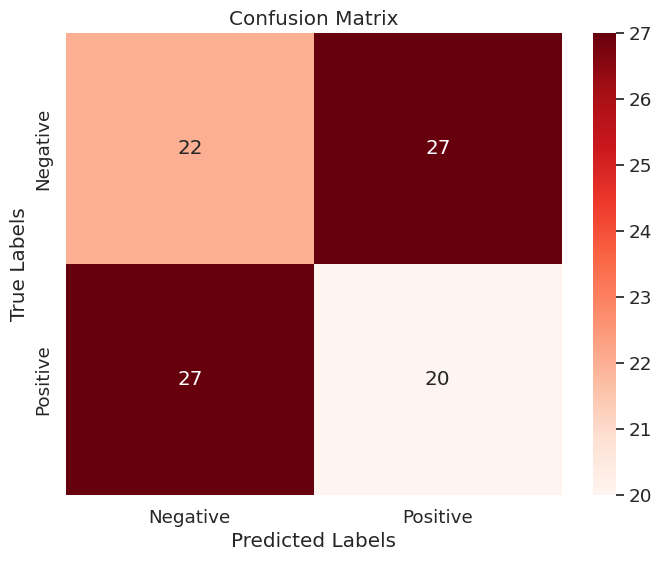

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Create a confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=class_names, yticklabels=class_names)

# Add labels and title
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

# Display the plot
plt.show()


In [ ]:
actual_labels = ['Weapon' if label == 1 else 'No weapon' for label in test_labels]
predicted_labels = ['Weapon' if label == 1 else 'No weapon' for label in predictions]

# Create a DataFrame to store the results
results_df = pd.DataFrame({
    'Image': range(len(test_labels)),
    'Actual_Label': actual_labels,
    'Predicted_Label': predicted_labels
})

results_df.to_csv("/content/NASNET_predictions.csv" , index=False)

In [ ]:
from google.colab import files
files.download('/content/NASNET_predictions.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>